In [1]:
from IPython.display import Image
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
import numpy as np
from scipy.fftpack import rfft, fft, fftshift
from scipy.signal import decimate
output_notebook()

Loading BokehJS ...

In [2]:
fs = 1
N = 1000
t = np.linspace(0, N/fs, N, endpoint=False)
R = 50
f = 0.01
a = 1
dc = 0
signal = a*np.sin(2*np.pi*f*t/fs) + dc
signal_vrms = np.sqrt(1/(N)*np.sum(np.square(signal)))
signal_avg_power = np.square(signal_vrms)

In [3]:
p = figure(title="", x_axis_label='Time (s)', y_axis_label='Amplitude (V)',plot_width=800, plot_height=300)
p.line(t, signal, legend="", line_width=2)
show(p)
print("Vrms =", signal_vrms)
print("Power (W|50hm) =", signal_avg_power/R)
print("Power (dBm) =", 10*np.log10(signal_avg_power/R)+30)

Vrms = 0.7071067811865476
Power (W|50hm) = 0.010000000000000002
Power (dBm) = 10.0


 Noise spectral density (nV/sqrt(Hz)) = 18
 Noise spectral density (dBm/Hz) = -142


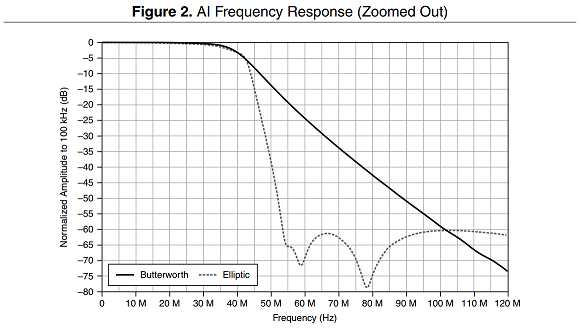

In [4]:
print(" Noise spectral density (nV/sqrt(Hz)) =", 18)
print(" Noise spectral density (dBm/Hz) =", -142)
Image("images/ai_frequency_response.png")

In [5]:
SNR_dB = 70 # 5783 Specs list 74.5 dBFS
noise = np.random.normal(0,1,N)
noise_vrms = np.sqrt(1/(N)*np.sum(np.square(noise)))
noise_avg_power = np.square(noise_vrms)
k = np.sqrt((signal_avg_power/noise_avg_power)*10**(-SNR_dB/10))
noise = k*noise
noise_vrms = np.sqrt(1/(N)*np.sum(np.square(noise)))
noise_avg_power = np.square(noise_vrms)

In [6]:
p = figure(title="", x_axis_label='Time (s)', y_axis_label='Amplitude (V)',plot_width=800, plot_height=300)
p.line(t, noise, legend="", line_width=2)
show(p)
print("Vrms =", noise_vrms)
print("Power (W) =", noise_avg_power/R)
print("Power (dBm) =", 10*np.log10(noise_avg_power/R)+30)

Vrms = 0.00022360679774997898
Power (W) = 1e-09
Power (dBm) = -60.0


In [7]:
fft_x = np.linspace(0, fs/(2.0), N//2, endpoint=False)
fft_y = fft(signal+noise)
fft_mag  = np.append(np.abs(fft_y[0]),np.abs(fft_y[1:N//2])*2)/N
fft_power = np.square(fft_mag)
fft_power_watt= fft_power/(2*R)
fft_power_dbm = 10*np.log10(fft_power_watt)+30

In [8]:
p = figure(title="", x_axis_label='Frequency (Hz)', y_axis_label='Power (dBm)',plot_width=800, plot_height=300)
p.line(fft_x, fft_power_dbm, legend="", line_width=2)
show(p)

In [14]:
f = -0.01
oscillator = a*np.cos(2*np.pi*f*t/fs) + 1j*a*np.sin(2*np.pi*f*t/fs)

In [15]:
fft_x = np.linspace(-fs/(2.0), fs/(2.0), N, endpoint=False)
fft_y = fftshift(fft(oscillator))
fft_mag  = np.abs(fft_y)*2/N
fft_power = np.square(fft_mag)
fft_power_watt= fft_power/(2*R)
fft_power_dbm = 10*np.log10(fft_power_watt)+30
p = figure(title="", x_axis_label='Frequency (Hz)', y_axis_label='Power (dBm)',plot_width=800, plot_height=300)
p.line(fft_x, fft_power_dbm, legend="", line_width=2)
show(p)

In [16]:
mixed_signal = oscillator * (signal + noise)

In [17]:
fft_x = np.linspace(-fs/(2.0), fs/(2.0), N, endpoint=False)
fft_y = fftshift(fft(mixed_signal))
fft_mag  = np.abs(fft_y)*2/N
fft_power = np.square(fft_mag)
fft_power_watt= fft_power/(2*R)
fft_power_dbm = 10*np.log10(fft_power_watt)+30
p = figure(title="", x_axis_label='Frequency (Hz)', y_axis_label='Power (dBm)',plot_width=800, plot_height=300)
p.line(fft_x, fft_power_dbm, legend="", line_width=2)
show(p)

### Notes
- Resulution budget will be important when code move to the FPGA. 
- ADC is 16 bits, which theoretically yields: SQNR = 20*log10(2^Q) = 96.33 dB.
- Rejection from the first filter is paramount so that the noise power does not alias in band of interest.
- The 5783 Elliptical analog filter has a sharp drop with a stop band of ~60 dB of rejection
- Should be looking at a multisage filter setup in the FPGA with preferrably a recursive filter (a.k.a IIR)
- http://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch19.pdf
- Decimation by 16 will let 15/16 of BW of noise power alias in.
- BW ~ 100M, 10*log10(100M) = 80 dB | why was 40 dB mentioned? <------
- Spurs from the NCO could be affecting the final result
- Rejection of the FPGA FIR rational decimator ~85 dB, stop band at 0.6 output data rate
- Final filter BW is 100 Hz, e.g. , you can expect a 60 dB theoretical improvement in SNR (10*log(100M) â€“ 10*log(100)).

In [19]:
factor = 50
decimated_signal = decimate(mixed_signal, factor, ftype='iir')
print(len(decimated_signal))
fft_x = np.linspace(-fs/(2.0), fs/(2.0), N//factor, endpoint=False)
fft_y = fftshift(fft(decimated_signal))
fft_mag  = np.abs(fft_y)*2/(N//factor)
fft_power = np.square(fft_mag)
fft_power_watt= fft_power/(2*R)
fft_power_dbm = 10*np.log10(fft_power_watt)+30
p = figure(title="", x_axis_label='Frequency (Hz)', y_axis_label='Power (dBm)',plot_width=800, plot_height=300)
p.line(fft_x, fft_power_dbm, legend="", line_width=2)
show(p)

20
